## Introduction to Cross Validation

### Paul Anzel, 10-20-15

Problem: I have a few different methods I'd like to try and do a fit (e.g. $k$-nearest-neighbors vs support-vector-machine) and I want to see which gives me better accuracy.

Or...

Problem: I don't have too much data, and I have a lot of possible parameters I could use for my statistical model fits. How can I choose among them?

I'm going to try fitting to some data with an initial model

$y = \beta_1 x_2 + \beta_2 x_3 + \beta_3 x_7 + 5$

$\beta_2 = 5$

$\beta_3 = 10$ <-- the most important one

$\beta_7 = 0.2$

But pretend I don't know about the values of the $\beta$'s.

In [1]:
from __future__ import division, print_function, unicode_literals

import sklearn
from sklearn import cross_validation
from sklearn import linear_model
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns

rd.seed(10000)
%matplotlib inline

In [2]:
N = 15

beta2 = 5
beta3 = 10
beta7 = 2
intercept = 50

eta = 40  # Random parameter

x1 = 10*(rd.rand(N) - .5)
x2 = 10*(rd.rand(N) - .5)
x3 = 10*(rd.rand(N) - .5)
x4 = 10*(rd.rand(N) - .5)
x5 = 10*(rd.rand(N) - .5)
x6 = 10*(rd.rand(N) - .5)
x7 = 10*(rd.rand(N) - .5)
x8 = 10*(rd.rand(N) - .5)
x9 = 10*(rd.rand(N) - .5)
x10 = 10*(rd.rand(N) - .5)


yvals = intercept + beta2*x2 + beta3*x3 + beta7*x7 + eta*rd.rand(N)

/Users/anzelp/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


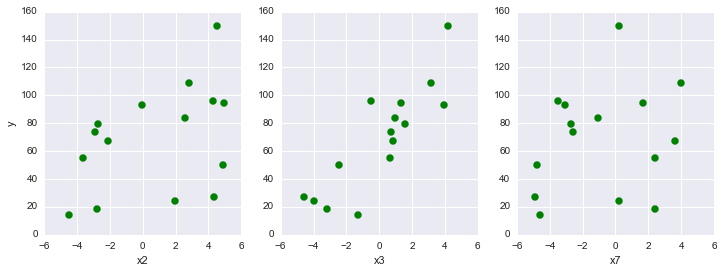

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(x2, yvals, s=50, color='g')
axes[0].set_xlabel('x2')
axes[0].set_ylabel('y')

axes[1].scatter(x3, yvals, s=50, color='g')
axes[1].set_xlabel('x3')

axes[2].scatter(x7, yvals, s=50, color='g')
axes[2].set_xlabel('x7')

In [16]:
x_collate = np.vstack((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)).T

clf_standard = linear_model.LinearRegression()
clf_standard.fit(x_collate, yvals)
print(clf_standard.intercept_)
print(clf_standard.coef_)
print(clf_standard.score(x_collate, yvals))

62.7891585249
[ -2.89937564   4.25268449  13.84027441   4.29652734   1.43866066
   5.19036671  -1.59254485  -5.60143668  -4.34299036  -0.45154377]
0.969906893742


In [15]:
for ind in range(10):
    exec('xtest = x%d' % (ind + 1))
    clf_simple = linear_model.LinearRegression()
    clf_simple.fit(xtest.reshape((N,1)), yvals.reshape((N,1)))
    print('x%d only coef: %.2f' % ((ind+1), clf_simple.coef_))

x1 only coef: 3.61
x2 only coef: 4.44
x3 only coef: 11.96
x4 only coef: -1.81
x5 only coef: -0.61
x6 only coef: -0.69
x7 only coef: 2.70
x8 only coef: -1.22
x9 only coef: -2.25
x10 only coef: -3.65


### Holdout CV

This is the most conventional way of doing things. In holdout, the data is split into two sets, the training set and the test set (say 70%/30% split). We run our fit on the training set, and then see what error values you get when you apply the fit to the test set.

In [28]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    x_collate, yvals, test_size=3, random_state=0)

clf_holdout=linear_model.LinearRegression().fit(X_train, Y_train)
print('First try with a score R^2 = %.2f'
      % clf_holdout.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    x_collate, yvals, test_size=3, random_state=10)

clf_holdout=linear_model.LinearRegression().fit(X_train, Y_train)
print('Second time with a score R^2 = %.2f'
      % clf_holdout.score(X_test, Y_test))

0.495774445169
-7.81171335028


### Random sub-sampling

Do holdout $k$ times (selecting your sets randomly each time). After having done this, take the average of your errors.

In [34]:
n_iter = 10

ss = cross_validation.ShuffleSplit(
    N, n_iter=n_iter, test_size=3, random_state=1337)

R2_list = np.empty((len(ss),))
ind = 0

for train, test in ss:
    print("TRAIN:", train, "TEST:", test)
    X_train = x_collate[train, :]
    X_test = x_collate[test, :]
    Y_train = yvals[train]
    Y_test = yvals[test]
    clf=linear_model.LinearRegression().fit(X_train, Y_train)
    R2_list[ind] = clf.score(X_test, Y_test)
    ind += 1
    
print(R2_list.mean())

TRAIN: [ 0  4  6 11  2 10  9 14  8 12 13  7] TEST: [5 3 1]
TRAIN: [ 3  0 13 12  2  9 14  1  8  7 10  6] TEST: [11  4  5]
TRAIN: [ 8  2  6  0  4 10  9 13 11  1  3  7] TEST: [14  5 12]
TRAIN: [ 3  8  9 10 13  5  2 11  4  6 12  1] TEST: [ 7  0 14]
TRAIN: [ 2  9 13  0  5 12  3  6  8 11  4 10] TEST: [14  7  1]
TRAIN: [ 4  7 11  5 14 13  8  3  0  2 12  1] TEST: [ 9 10  6]
TRAIN: [11  3  9  8  5  6  4  7 12  0  2 13] TEST: [ 1 14 10]
TRAIN: [ 4 13  8  3  7 11 14  0 12  9  5  2] TEST: [ 6 10  1]
TRAIN: [10  5  1  8 12  7 14  9  3 13 11  0] TEST: [2 4 6]
TRAIN: [14  3 13  2  8 11  6  1  7  4  9 12] TEST: [ 5  0 10]
-2.79454396274


### LOOCV (Leave-one-out-cross-validation)

In this technique, you'll take one data point out ($x_i$), and run your model fitting $\hat y_{-i} = f(X_{-i})$ on the rest of the set. Calculate the error $e_{-i} = \hat y_{-i} - y_i$. Next, repeat the process for each of the other data points $i = 1, ..., n$. Average the results, and you have your CV statistic.

You can also average things like $R^2$ statistics instead (using scikit-learn's `clf.score()`).

In [ ]:
loo = cross_validation.LeaveOneOut(N)

for train, test in loo:
    print("TRAIN:", train, "TEST:", test)
    X_train = x_collate[train, :]
    X_test = x_collate[test, :]
    Y_train = yvals[train]
    Y_test = yvals[test]
    # ...

This can be a bit slow to do if you're implementing your own routine (SKLearn should have it optimized), but if you've got a linear regression system

$y = X \bar \beta + \bar e$

You would (in a typical least-squares) compute

$\hat \beta = (X^T X)^{-1} X^T y$

$\hat y = X \hat \beta = X (X^T X)^{-1} X^T y = H y$

And the cross-validation statistic can be computed

$CV = \frac{1}{n} \sum_{i=0}^n [e_i / (1-H_{ii})]^2$

Where $e_i$ are the residuals of the fit to all $n$ points.

A few additional notes:
- LOOCV will not consistently (as $n \rightarrow \infty$) settle on a fit model ([Jun Shao, 1993](https://www.jstor.org/stable/2290328?&seq=1#page_scan_tab_contents)). This may not be a problem, as the real world barely follows nice models anyway.

### LpOCV (Leave-p-out-cross-validation)

This is an extension of above, except rather than leaving 1 data point out and running $n$ different fits, you leave $p$ units out and do $\frac{n!}{p! (n-p)!}$ (choosing all possible $p$-sized subsets) different statistical fits. Note that this can become fairly unweildly is $n$ is decently sized, so be warned.

Like LOOCV, you'll run your fits on the n-choose-p take-p-out data sets, find the error on them, and average out all the results.

In [ ]:
p = 2

lpo = cross_validation.LeaveOneOut(N, p=p)

for train, test in lpo:
    print("TRAIN:", train, "TEST:", test)
    X_train = x_collate[train, :]
    X_test = x_collate[test, :]
    Y_train = yvals[train]
    Y_test = yvals[test]
    # ...

### $k$-Fold CV

A different extension of LOOCV/LpOCV. Shuffle your data and divide it into $k$ subsets. Run your fitting $k$ times, where the $k^{th}$ subset is your test set and the rest are your training sets. Average your error among all of the different sets, as before.

In [39]:
n_folds = 3

kf = cross_validation.KFold(N, n_folds=n_folds)

R2_list = np.empty((len(kf),))
ind = 0

for train, test in kf:
    print("TRAIN:", train, "TEST:", test)
    X_train = x_collate[train, :]
    X_test = x_collate[test, :]
    Y_train = yvals[train]
    Y_test = yvals[test]
    clf=linear_model.LinearRegression().fit(X_train, Y_train)
    R2_list[ind] = clf.score(X_test, Y_test)
    ind += 1
    
print(R2_list)

TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [0 1 2 3 4]
TRAIN: [ 0  1  2  3  4 10 11 12 13 14] TEST: [5 6 7 8 9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11 12 13 14]
[-7.65582374  0.51350169 -1.46836761]


Trade off:

- If you have a lot of fits (e.g. $k$ is pretty large in $k$-fold) the bias of your error estimator will be small (you'll be accurate) but it'll have large variance (low precision). This can also possibly take a long time to compute.
- If you have a few fits (small $k$) the bias will be larger (higher than the true error rate) but will have less variance. Faster to compute.

For large datasets, $k = 3$ is pretty reasonable. For very small ones, look to LOOCV. $k=10$ is a common choice.

### Scikit-Learn does this for you

In [36]:
cv = cross_validation.cross_val_score(
    linear_model.LinearRegression(), # Estimator
    x_collate,
    yvals,
    cv=3 # Defaults to 3-Fold, can put in other generator (as above)
)
print(cv)

[-7.65582374  0.51350169 -1.46836761]


### Time series data

When doing time series, you want to test on the most recent data (so you're not just interpolating. Plus, it's clear that the data is not IID any longer.

One technique:
- Fit model to data $y_1, ..., y_t$. Find the forecast $\hat y_{t+1}$ and compute prediction error $e_{t+1}$.
- Repeat this for $t = m, ..., n-1$ where $m$ is the minimum number of steps needed to fit the model.
- Average errors (as before).

Other notes:
- There are Stratification techniques, where you split your different categories (e.g. for classification) so that you get a (roughly) even partition of your different classes in your test groups (e.g. `cross_validation.StratifiedKFold`).
- Similarly, for labeled categories you have methods like Leave-One-Label-Out and Leave-P-Labels-Out

Sources:
- http://robjhyndman.com/hyndsight/crossvalidation/
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)